## Business Understanding

Choose stakeholder and figure out what they care about

- need two important parameter estimates as recommendations


## Exploratory Data Analysis

How/why does this data allow you to answer your questions?

**Data Visualization**
- Need 3 High Quality Data Visualizations

## Data Prep/Feature Eng

**Train/Test/Split**

**General Data Preparation**
- Nulls/dupes/outliers
- scaling
- transformations (for linearity)

**Feature Engineering**
- Encoding Variables (categories)
- Polynomial Features
- Interaction Terms
- NEED ONE NON-NUMERIC FEATURE

## Iterative Modeling

First try simplest approach.

Consider what the model baseline is

Start Adding Complexity and compare along the way
(**DOCUMENT THE ITERATIVE PROCESS**)

Models need to adhere to the assumptions of linear regression. If models do not adhere need to at least show that assumptions were tested for:

**ASSUMPTIONS**
- linear relationship between x and y - Heatmaps, scatter matrix
- low multicollinearituy - heatmaps, scatter matrix, VIF
- normal distribution of errors - kde, histogram, QQ-Plot, quantitative check (Jarque-Bera)
- homoskedasticity between errors - scatter plot between true and expected value

## Model Interpretation

Check for statistical Significance - check p-values of input variables

Are coefficients interpretable

Check R2, RMSE, MAE, MSE and other regression metrics

-----------------------


## STAKEHOLDER SELECTION

Stakeholder is Redfin

- Develop model to determine optimal purchasing price of homes and what renovations to make that will lead to greatest ROI


## BUSINESS UNDERSTANDING

**70% Rule:**

$$ 
MBP = (0.7ARV) - ERC
$$

where:

MBP = Maximum Buying Price

ARV = After-repair value

ERC = Estimated repair costs

in a sellers market we can adjust 70% to as high as 85%

## DATA EXPLORATION

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from folium.plugins import FastMarkerCluster
import folium

## Feature Selection

In [70]:
num_features_to_select = 6

# Use RSE or use manual formula string
use_RSE = False
formula_string = 'sqft_living+view+grade+living_area+suburb+rural'

In [71]:
df = pd.read_csv('data/cleaned_data.csv')
df.drop(['id','date','Unnamed: 0'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)

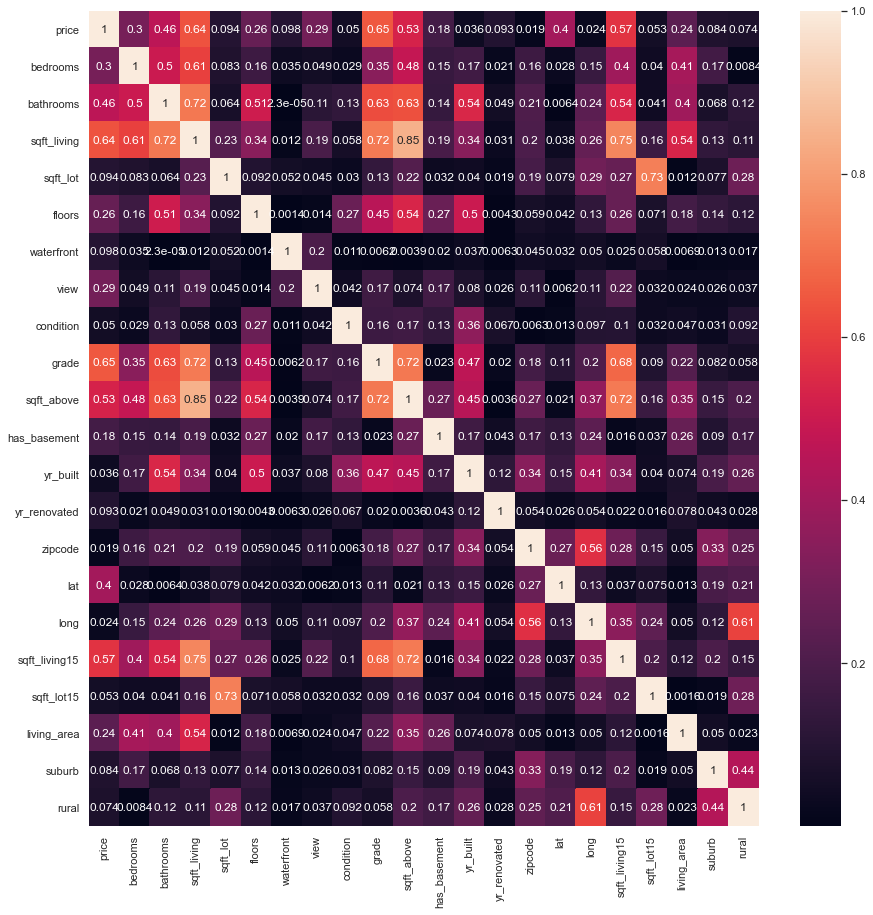

In [72]:
sns.set(rc={'figure.figsize':(15, 15)})

# Use the .heatmap method to depict the relationships visually!
sns.heatmap(df.corr().abs(),annot=True);

In [73]:
df_suburb = df[(df['rural'] == 1)]

In [74]:
# Divide King County up into sections and create a model for each section

lat = 47.5
long = -122.15
# Initialize a folium map to plot points
my_map = folium.Map([lat, long], zoom_start=9)


coordinates = [
    # Seattle
    [47.503347, -122.255819],
    [47.777799, -122.255819],
    [47.777799, -122.419374],
    [47.503347, -122.419374],
    [47.503347, -122.255819]
]

not_seattle = [
    [47.777799, -122.255819],
    [47.777799, -121.864468],
    [47.583466, -121.864468],
    [47.583466, -121.657316],
    [47.426793, -121.657316],
    [47.426793, -121.847579],
    [47.163963, -121.847579],
    [47.163963, -122.139281],
    [47.257529, -122.139281],
    [47.257529, -122.327981],
    [47.333580, -122.435077],
    [47.333580, -122.516673],
    [47.503347, -122.516673],
    [47.503347, -122.419374]
    
]

suburbs = [
    [47.777799, -121.998473],
    [47.362637, -122.003149],
    [47.288093, -122.177545],
    [47.257529, -122.249917]

]
# Plot lines using coordinates
my_PolyLine=folium.PolyLine(locations=not_seattle,weight=5)
my_map.add_child(my_PolyLine)
my_PolyLine=folium.PolyLine(locations=suburbs,weight=5)
my_map.add_child(my_PolyLine)
my_PolyLine=folium.PolyLine(locations=coordinates,weight=5)
my_map.add_child(my_PolyLine)
# add all the point from the file to the map object using FastMarkerCluster
my_map.add_child(FastMarkerCluster(df_suburb[['lat', 'long']].values.tolist()))

my_map

In [75]:
# Shows base dataset corrs
df_base = pd.read_csv('data/kc_house_data.csv')
df_base.drop(['id','date','yr_renovated'],axis=1,inplace=True)
df_base_corrs = df_base.corr()['price'].map(abs).sort_values(ascending=False)
df_base_corrs[:5]

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
Name: price, dtype: float64

In [76]:
# Shows cleaned dataset corrs
df_corrs = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corrs[:5]

price            1.000000
grade            0.649461
sqft_living      0.639017
sqft_living15    0.572739
sqft_above       0.530734
Name: price, dtype: float64

In [77]:
# Create Train and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.2, random_state=42)

In [78]:
# Fit Scalar to Train
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [79]:
# Recursive Feature Selection
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=num_features_to_select)
select.fit(X=X_train_scaled, y=y_train)


keep_list = [(k,v) for k,v in zip(df.drop('price', axis=1).columns,select.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
if use_RSE == False:
    keep_list = formula_string.split('+')
keep_string = keep_string[:-1]

In [80]:
# Creates scaled features dataframe and then adds on price column

# Train
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = df.drop('price', axis=1).columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled,y_train),axis=1)

# Test
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = df.drop('price', axis=1).columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

----------------

## Model Results

In [81]:
# Baseline Model

baseline_mean = X_train_scaled_final['price'].mean()
model_base = DummyRegressor(strategy='mean', constant=baseline_mean)
baseline_mean

499116.46736483194

In [82]:
# OLS Regression on Train Data

if use_RSE == False:
    keep_string = formula_string

formula = f'price ~ {keep_string}'
model = ols(formula,X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     4160.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:47:02   Log-Likelihood:            -2.1997e+05
No. Observations:               16424   AIC:                         4.400e+05
Df Residuals:                   16417   BIC:                         4.400e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.991e+05   1237.915    403.191      0.000    4.97e+05    5.02e+05
sqft_living  1.372e+05   2315.718     59.233      0.000    1.33e+05    1.42e+05
view         3.025e+04   1283.990     23.556      0.000    2.77e+04    3.28e+04
grade        7.914e+04   1890.168     41.868      0.000    7.54e+04    8.28e+04
living_area -3.742e+04   1598.965    -23.403      0.000   -4.06e+04   -3.43e+04
suburb      -7.799e+04   1464.703    -53.249      0.000   -8.09e+04   -7.51e+04
rural       -7.263e+04   1454.820    -49.926      0.000   -7.55e+04   -6.98e+04
==============================================================================
Omnibus:                     3224.274   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9752.470
Skew:                           1.018   Prob(JB):                         0.00
Kurtosis:                       6.179   Cond. No.                         3.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
# OLS Regression on Test Data

model_test = ols(formula,X_test_scaled_final).fit()
model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     936.6
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:47:02   Log-Likelihood:                -54966.
No. Observations:                4106   AIC:                         1.099e+05
Df Residuals:                    4099   BIC:                         1.100e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.955e+05   2462.111    201.251      0.000    4.91e+05       5e+05
sqft_living  1.319e+05   4563.246     28.912      0.000    1.23e+05    1.41e+05
view         2.957e+04   2535.904     11.662      0.000    2.46e+04    3.45e+04
grade        7.619e+04   3756.342     20.282      0.000    6.88e+04    8.36e+04
living_area  -3.27e+04   3090.575    -10.582      0.000   -3.88e+04   -2.66e+04
suburb      -8.102e+04   2893.797    -27.998      0.000   -8.67e+04   -7.53e+04
rural       -7.402e+04   2873.775    -25.757      0.000   -7.97e+04   -6.84e+04
==============================================================================
Omnibus:                      828.444   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2629.212
Skew:                           1.019   Prob(JB):                         0.00
Kurtosis:                       6.348   Cond. No.                         3.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-------------

## MODEL VALIDATION

### Check Normal Distribution of Input Variables

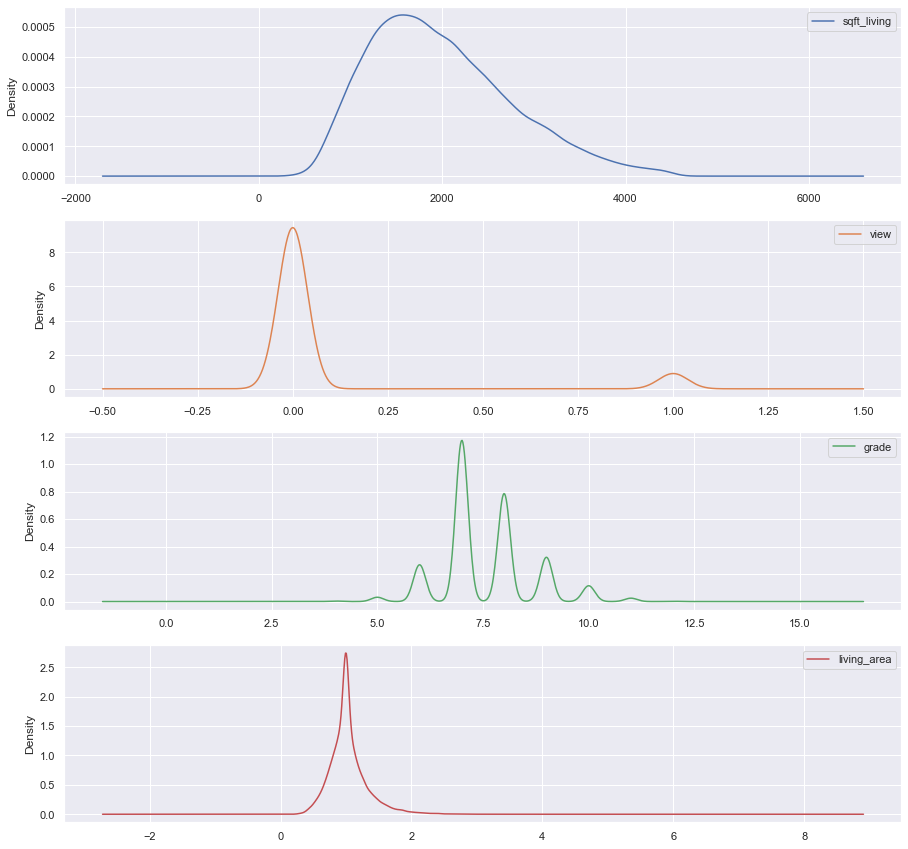

In [65]:
if use_RSE:
    df.filter([x[0] for x in keep_list if x[1] == True],axis=1).plot.kde(subplots=True,sharex=False)
else:
    df.filter(keep_list,axis=1).plot.kde(subplots=True,sharex=False)
plt.show()

### Checking Normal Distribution of Residuals

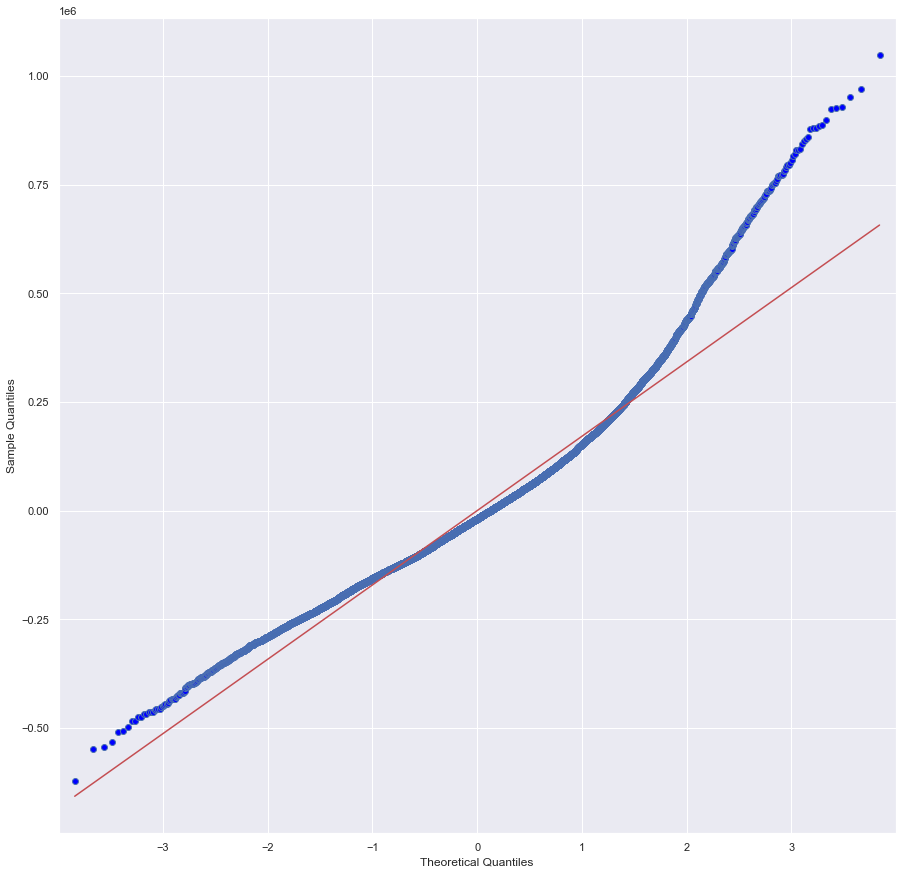

In [66]:
y_hat_train = model.predict(X_train_scaled)
y_hat_test = model_test.predict(X_test_scaled)

qqplot(y_train-y_hat_train,line='r')
plt.show()

### Checking for Heteroskedasticity and Lack of Trend in Errors

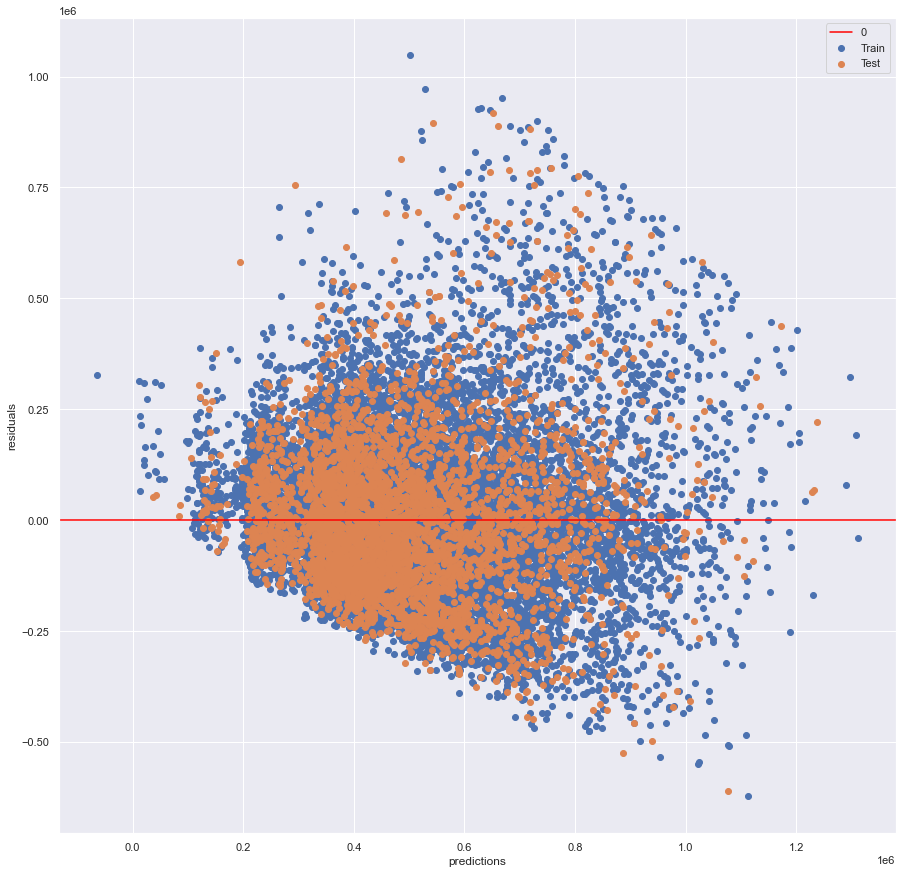

In [67]:
plt.scatter(y_hat_train, y_train - y_hat_train, label='Train')
plt.scatter(y_hat_test, y_test - y_hat_test, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Checking Root Mean Squared Error

In [68]:
print('TRAIN RMSE:',rmse(y_train,y_hat_train))
print('TEST RMSE:',rmse(y_test,y_hat_test))
print('RMSE DIFF:', abs(rmse(y_train,y_hat_train)-rmse(y_test,y_hat_test)))

TRAIN RMSE: 174955.42919257027
TEST RMSE: 175292.7502811593
RMSE DIFF: 337.3210885890294


### Checking Linearity and Multicollinearity

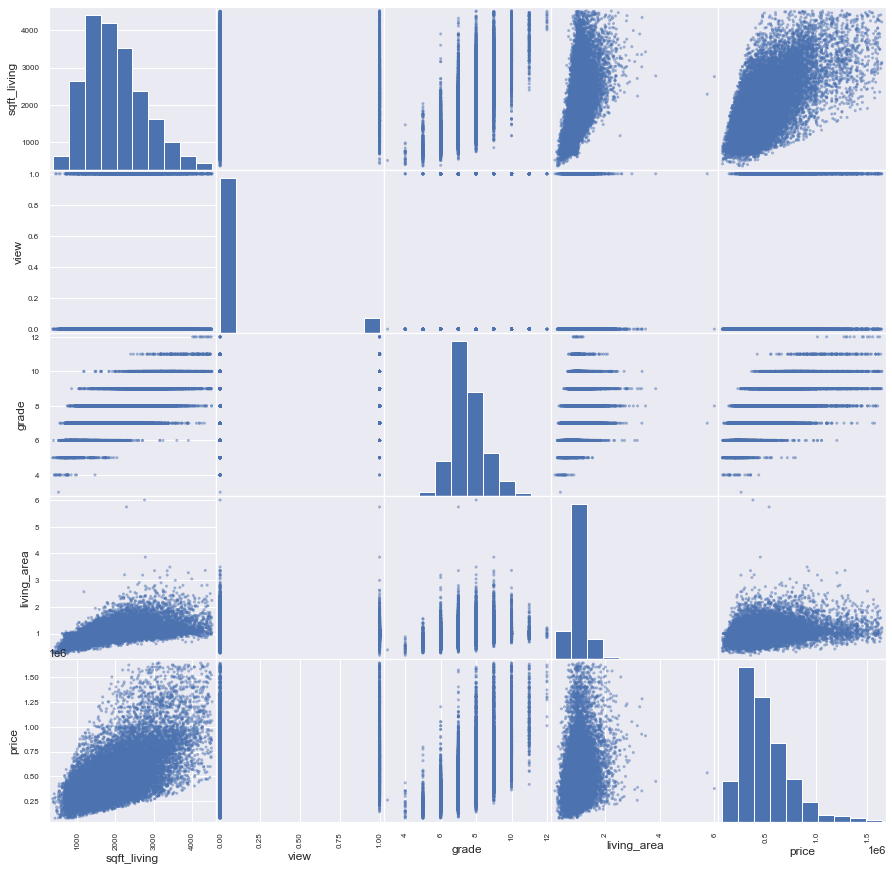

In [69]:
if use_RSE:
    scatter_keep_list = keep_list.copy()
    scatter_keep_list.append(('price',True))
    pd.plotting.scatter_matrix(df.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1))
    plt.show()

else:
    scatter_keep_list = keep_list.copy()
    scatter_keep_list.append('price')
    pd.plotting.scatter_matrix(df.filter(scatter_keep_list,axis=1))
    plt.show()

In [22]:
if use_RSE:
    corr_print = X_train_scaled_final.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs()['price'].sort_values(ascending=False)
else:
    corr_print = X_train_scaled_final.filter(scatter_keep_list,axis=1).corr().abs()['price'].sort_values(ascending=False)
corr_print

price          1.000000
grade          0.655304
sqft_living    0.643200
living_area    0.236327
suburb         0.077766
rural          0.075556
Name: price, dtype: float64

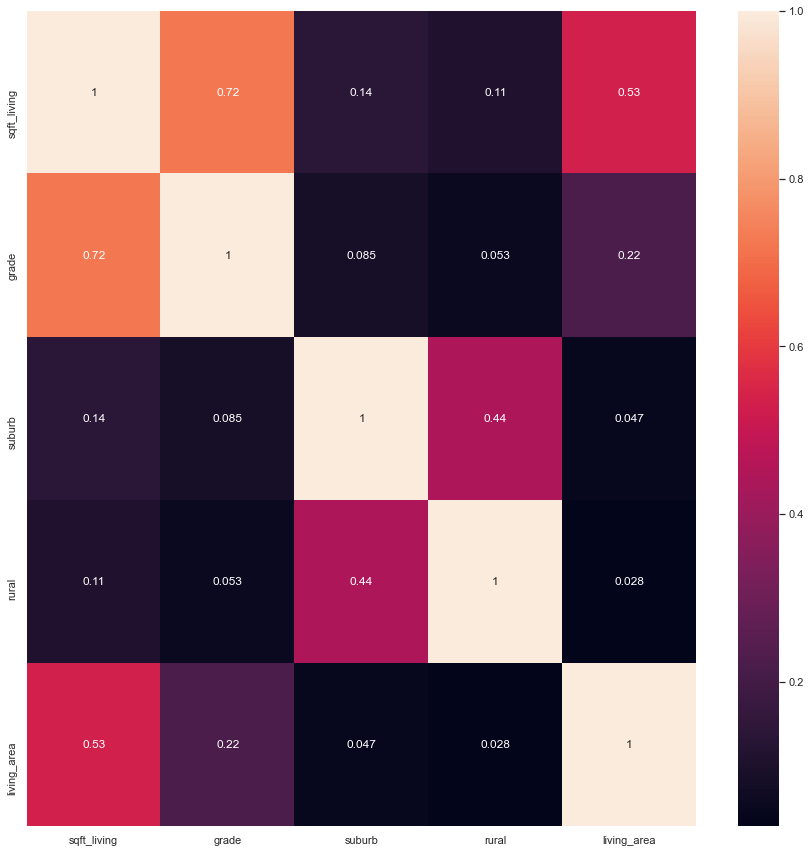

In [23]:
if use_RSE:
    sns.heatmap(X_train_scaled.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs(),annot=True)
else:
    sns.heatmap(X_train_scaled.filter(keep_list,axis=1).corr().abs(),annot=True)